In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from models.microstruc_multiFrames_GINOT import LoadModel
from models import configs
from torch.utils.data import DataLoader
from tqdm import tqdm
import time
import pyvista as pv
import json
import pickle
from IPython.display import HTML, display_html
device = "cuda" if torch.cuda.is_available() else "cpu"



In [11]:
# TODO: change backend to "html" for higher resolution and interactive plots
pv_bc = "html"  # "static", "html", "client"
b_GIF=False
pv.set_jupyter_backend(pv_bc)
# pv.global_theme.trame.jupyter_extension_enabled = True
# pv.global_theme.trame.server_proxy_enabled = True
if pv_bc == "static":
    window_size = (1280*2, 700*2)
else:
    window_size = (1360, 800)
show_edges = True


In [3]:
configs_load = configs.microstruc_multiFrames_GINOT_configs()

filebase = configs_load["filebase"]
trunk_args = configs_load["trunk_args"]
branch_args = configs_load["branch_args"]
ginot = LoadModel(filebase, branch_args, trunk_args)
print("filebase: ", filebase)
print("trunk_args: ", trunk_args)
print("branch_args: ", branch_args)



Total number of parameters of Geo encoder: 852529, 852529 of which are trainable
Total number of parameters of NTO model: 2291071, 2291071 of which are trainable
filebase:  /work/hdd/bdsy/qibang/repository_Wbdsy/GINOT/models/saved_weights/microstruc_26frames_GINOT
trunk_args:  {'embed_dim': 128, 'cross_attn_layers': 4, 'num_heads': 8, 'num_frames': 26, 'dropout': 0.0, 'padding_value': -1000}
branch_args:  {'input_channels': 2, 'out_c': 128, 'latent_d': None, 'width': 128, 'n_point': 128, 'n_sample': 8, 'radius': 0.2, 'd_hidden': [128, 128], 'num_heads': 4, 'cross_attn_layers': 2, 'self_attn_layers': 2, 'fps_method': 'fps', 'pc_padding_val': -1000, 'dropout': 0.0}


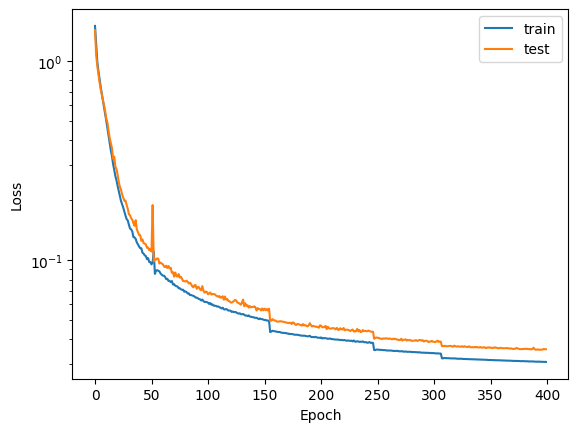

In [4]:
loss_file = filebase + "/logs.json"
with open(loss_file, 'r') as f:
    data = json.load(f)
plt.plot(data['loss'], label='train')
plt.plot(data['val_loss'], label='test')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()



In [5]:


def predict(data_loader, ginot, su_inverse, error_fn=None):
    y_pred = []
    y_true = []
    verts_all = []
    pc_all = []
    sample_ids = np.empty(0, dtype=int)
    error = []
    ginot.eval()
    with torch.no_grad():
        for data in tqdm(data_loader, desc="Predicting"):
            pc = data[0].to(device)  # (B, N, 2)
            xyt = data[1].to(device)  # (B, N, 2)
            y_true_batch = data[2].to(device)  # (B, N)
            mask = (y_true_batch != ginot.padding_value)
            pred = ginot(xyt, pc)
            pred = su_inverse(pred)
            y_true_batch = su_inverse(y_true_batch)
            pred = [x[i].view(-1, *i.shape[1:]).cpu().detach().numpy()
                    for x, i in zip(pred, mask)]
            y_true_batch = [x[i].view(-1, *i.shape[1:]).cpu().detach().numpy()
                            for x, i in zip(y_true_batch, mask)]
            if error_fn is not None:
                error = error.append(error_fn(pred, y_true_batch))
            else:
                y_pred = y_pred+pred
                y_true = y_true+y_true_batch
                mask_verts = (
                    xyt != configs.PADDING_VALUE).cpu().detach().numpy()
                verts_all = verts_all+[x[i].view(-1, *i.shape[1:]).cpu().detach().numpy()
                                       for x, i in zip(xyt, mask_verts)]
                pc_all = pc_all+[x.cpu().detach() for x in pc]
                sample_ids = np.append(
                    sample_ids, data[3].cpu().detach().numpy())
    if error_fn is not None:
        return np.concatenate(error)
    else:
        return y_pred, y_true, verts_all, pc_all, sample_ids


def cal_l2_error(y_pred, y_true):
    error_s = []
    for y_p, y_t in zip(y_pred, y_true):
        s_p, s_t = y_p[:, :, 0], y_t[:, :, 0]
        ux_p, ux_t = y_p[:, :, 1], y_t[:, :, 1]
        uy_p, uy_t = y_p[:, :, 2], y_t[:, :, 2]
        e_s = np.linalg.norm(s_p-s_t)/np.linalg.norm(s_t)
        e_ux = np.linalg.norm(ux_p-ux_t)/np.linalg.norm(ux_t)
        e_uy = np.linalg.norm(uy_p-uy_t)/np.linalg.norm(uy_t)
        error_s.append((e_s+e_ux+e_uy)/3)
    error_s = np.array(error_s)
    return error_s



In [6]:
# train_dataloader, test_dataloader, _, su_inverse = configs.LoadDataMicroSturcGeo(
#     bs_train=32, bs_test=32, num_frames=26, load_cells="NO")
# time_start = time.time()
# error_s = predict(
#     train_dataloader, ginot, su_inverse, error_fn=cal_l2_error)
# time_end = time.time()
# print(f"Time taken to predict all samples: {time_end-time_start:.2e} seconds")
# print(
#     f"Time taken to predict one sample: {(time_end-time_start)/len(error_s):.2e} seconds")
# sort_idx = np.argsort(error_s)
# mean, std = np.mean(error_s), np.std(error_s)
# print(f"Mean L2 error of train dataset: {mean}, std: {std}")

In [7]:

def save_load_results(b_predict=True, save=False):
    if b_predict:
        _, test_dataloader, _, su_inverse = configs.LoadDataMicroSturcGeo(
            bs_train=32, bs_test=32, num_frames=26, load_cells="NO")
        time_start = time.time()
        su_pred_test, su_true_test, verts_all_test, pc_all_test, sample_ids_test = predict(
            test_dataloader, ginot, su_inverse)
        time_end = time.time()
        print(
            f"Time taken to predict one sample: {(time_end-time_start)/len(su_pred_test):.2e} seconds")
        data_dic = {"su_pred_test": su_pred_test, "su_true_test": su_true_test, "pc_all_test": pc_all_test,
                    "verts_all_test": verts_all_test, "sample_ids_test": sample_ids_test}
        if save:
            with open(filebase+'/test_results.pkl', 'wb') as f:
                pickle.dump(data_dic, f)
    else:
        # read the results from the pickle file
        with open(filebase+'/test_results.pkl', 'rb') as f:
            results = pickle.load(f)
            su_pred_test = results['su_pred_test']
            su_true_test = results['su_true_test']
            verts_all_test = results['verts_all_test']
            sample_ids_test = results['sample_ids_test']
            pc_all_test = results['pc_all_test']
    return su_pred_test, su_true_test, verts_all_test, pc_all_test, sample_ids_test


su_pred_test, su_true_test, verts_all_test, pc_all_test, sample_ids_test = save_load_results(
    b_predict=False, save=False)



Mean L2 error of stress: 0.0905763654959716, std: 0.030218177095191978
Index 0 for Best: 9530, error: 0.03369303544362386
Index 1 for 32% percentile: 6342, error: 0.07577503224213918
Index 2 for 64% percentile: 10004, error: 0.09348162015279134
Index 3 for 99% percentile: 7869, error: 0.18843374649683634


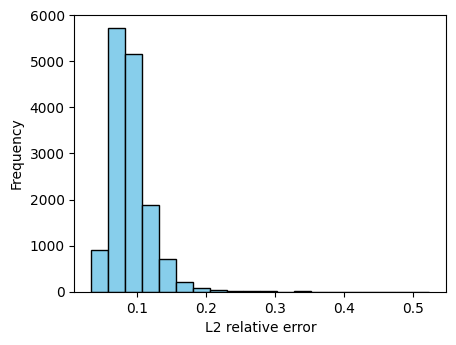

In [8]:


error_s = cal_l2_error(su_pred_test, su_true_test)
mean, std = np.mean(error_s), np.std(error_s)
sort_idx = np.argsort(error_s)
fig = plt.figure(figsize=(4.8, 3.6))
ax = plt.subplot(1, 1, 1)

_ = ax.hist(error_s[sort_idx[:-2]], bins=20,
            color="skyblue", edgecolor="black")
ax.set_xlabel("L2 relative error")
ax.set_ylabel("Frequency")

print(f"Mean L2 error of stress: {mean}, std: {std}")


titles = ["Best", "32% percentile", "64% percentile", "99% percentile"]
min_index = sort_idx[0]
max_index = sort_idx[int(len(sort_idx)*0.99-1)]
median_index = sort_idx[int(len(sort_idx) * 0.32)]
median_index2 = sort_idx[int(len(sort_idx) * 0.64)]
indices = np.array([min_index, median_index, median_index2, max_index])
for i in range(len(indices)):
    print(
        f"Index {i} for {titles[i]}: {indices[i]}, error: {error_s[indices[i]]}")



In [12]:
def get_pvstyle_cells(cells_np):
    """cells_np is a numpy array of shape (N, 4)"""
    cell_types = np.zeros(len(cells_np), dtype=int)
    cells = np.empty((0,), dtype=int)
    for i, c in enumerate(cells_np):
        c = c-1  # abaqus uses 1-based index
        if c[-1] == c[-2]:
            cell_types[i] = pv.CellType.TRIANGLE
            cells = np.append(cells, np.array([3, *(c[:-1])]))
        else:
            cell_types[i] = pv.CellType.QUAD
            cells = np.append(cells, np.array([4, *c]))
    return cells, cell_types


def plot_results(su_true, su_pred, cells_np, verts,
                 label="Mises stress [MPa]", opacity=1.0,
                 cmap="viridis", pc_color='green', point_size=8.0,
                 notebook=None, show_edges=True,
                 html_file=None, window_size=(1024, 256)):
    """
    su_true: (N,8,3)
    """
    Nt = su_true.shape[1]
    max_s, min_s = np.max(su_true[:, -1, 0]), np.min(su_true[:, -1, 0])
    error_s = np.abs(su_true[:, -1, 0]-su_pred[:, -1, 0])
    max_e, min_e = np.max(error_s), np.min(error_s)
    cells, cell_types = get_pvstyle_cells(cells_np)
    meshes_t = []
    meshes_p = []
    plotter = pv.Plotter(shape=(3, Nt), notebook=notebook,
                         window_size=window_size, border=False)
    lables_t = [
        f"True Mises stress [MPa] at strain = {((i)*3.2+4):.1f}%" for i in range(Nt)]
    lables_p = [
        f"Pred. Mises stress [MPa] at strain = {((i)*3.2+4):.1f}%" for i in range(Nt)]
    lables_e = [
        f"Abs. error [MPa] at strain = {((i)*3.2+4):.1f}%" for i in range(Nt)]
    for i in range(Nt):
        sigma_true, sigma_pred = su_true[:, i, 0], su_pred[:, i, 0]
        error = np.abs(sigma_true-sigma_pred)
        defomred_verts_t = verts + su_true[:, i, 1:3]
        defomred_verts_t = np.hstack(
            (defomred_verts_t, np.zeros((defomred_verts_t.shape[0], 1))))

        mesh_t = pv.UnstructuredGrid(
            cells, cell_types, defomred_verts_t)
        mesh_t.point_data[lables_t[i]] = sigma_true
        plotter.subplot(0, i)
        plotter.add_mesh(mesh_t, scalars=lables_t[i],
                         show_edges=show_edges, opacity=opacity, cmap=cmap, clim=[min_s, max_s])
        plotter.view_xy()

        defomred_verts_p = verts + su_pred[:, i, 1:3]
        defomred_verts_p = np.hstack(
            (defomred_verts_p, np.zeros((defomred_verts_p.shape[0], 1))))
        mesh_p = pv.UnstructuredGrid(
            cells, cell_types, defomred_verts_p)
        mesh_p.point_data[lables_p[i]] = sigma_pred
        plotter.subplot(1, i)
        plotter.add_mesh(mesh_p, scalars=lables_p[i],
                         show_edges=show_edges, opacity=opacity,
                         cmap=cmap, clim=[min_s, max_s])
        plotter.view_xy()

        mesh_e = pv.UnstructuredGrid(
            cells, cell_types, defomred_verts_t)
        mesh_e.point_data[lables_e[i]] = error
        plotter.subplot(2, i)
        plotter.add_mesh(mesh_e, scalars=lables_e[i],
                         show_edges=show_edges, opacity=opacity, cmap=cmap, clim=[min_e, max_e])
        plotter.view_xy()

    plotter.show()


def plot_results_animation(file_name,pc, su_true, su_pred, cells_np, verts,
                           label="Mises stress [MPa]", opacity=1.0,
                           cmap="viridis", fps=10,pc_color='green', point_size=8.0,
                           notebook=None, show_edges=True,
                           window_size=(2548, 768)):
    """
    su_true: (N,Nt,3)
    """
    cells, cell_types = get_pvstyle_cells(cells_np)

    Nt = su_true.shape[1]
    max_s, min_s = np.max(su_true[:, -1, 0]), np.min(su_true[:, -1, 0])
    error_s = np.abs(su_true[:, -1, 0]-su_pred[:, -1, 0])
    max_e, min_e = np.max(error_s), np.min(error_s)

    plotter = pv.Plotter(shape=(1, 4), notebook=notebook,
                         window_size=window_size, border=False)
    text_actor = plotter.add_text(
        "strain = 0", position='upper_left', font_size=20)

    # Open a mv file
    extnsion = file_name.split('.', 1)[-1]
    if extnsion == 'gif':
        plotter.open_gif(file_name, fps=fps)
    else:
        plotter.open_movie(file_name, framerate=fps)
        # plotter.show(auto_close=False)

    plotter.subplot(0, 0)
    pc = np.hstack((pc, np.zeros((pc.shape[0], 1))))
    pc_mesh = pv.PolyData(pc)
    plotter.add_mesh(pc_mesh, color=pc_color, point_size=point_size)
    plotter.view_xy()

    lables_t = "True Mises stress [MPa], True deformation"
    lables_p = "Pred. Mises stress [MPa], Pred. deformation"
    lables_e = "Abs. error [MPa], True deformation"
    i = 0
    sigma_true, sigma_pred = su_true[:, i, 0], su_pred[:, i, 0]
    error = np.abs(sigma_true-sigma_pred)

    defomred_verts_t = verts + su_true[:, i, 1:3]
    defomred_verts_t = np.hstack(
        (defomred_verts_t, np.zeros((defomred_verts_t.shape[0], 1))))
    mesh_t = pv.UnstructuredGrid(
        cells, cell_types, defomred_verts_t)
    mesh_t[lables_t] = sigma_true
    plotter.subplot(0, 1)
    plotter.add_mesh(mesh_t, scalars=lables_t,
                     show_edges=show_edges, opacity=opacity, cmap=cmap, clim=[min_s, max_s])
    plotter.view_xy()

    defomred_verts_p = verts + su_pred[:, i, 1:3]
    defomred_verts_p = np.hstack(
        (defomred_verts_p, np.zeros((defomred_verts_p.shape[0], 1))))
    mesh_p = pv.UnstructuredGrid(
        cells, cell_types, defomred_verts_p)
    mesh_p[lables_p] = sigma_pred
    plotter.subplot(0, 2)
    plotter.add_mesh(mesh_p, scalars=lables_p,
                     show_edges=show_edges, opacity=opacity,
                     cmap=cmap, clim=[min_s, max_s])
    plotter.view_xy()

    mesh_e = pv.UnstructuredGrid(
        cells, cell_types, defomred_verts_t)
    mesh_e[lables_e] = error
    plotter.subplot(0, 3)
    plotter.add_mesh(mesh_e, scalars=lables_e,
                     show_edges=show_edges, opacity=opacity, cmap=cmap, clim=[min_e, max_e])
    plotter.view_xy()

    plotter.write_frame()

    for i in range(1, Nt):
        text_actor.set_text('upper_left', f"strain = {i*0.8:.1f}%")
        sigma_true, sigma_pred = su_true[:, i, 0], su_pred[:, i, 0]
        error = np.abs(sigma_true-sigma_pred)

        defomred_verts_t = verts + su_true[:, i, 1:3]
        defomred_verts_t = np.hstack(
            (defomred_verts_t, np.zeros((defomred_verts_t.shape[0], 1))))

        defomred_verts_p = verts + su_pred[:, i, 1:3]
        defomred_verts_p = np.hstack(
            (defomred_verts_p, np.zeros((defomred_verts_p.shape[0], 1))))

        mesh_t[lables_t] = sigma_true
        mesh_t.points = defomred_verts_t
        mesh_p[lables_p] = sigma_pred
        mesh_p.points = defomred_verts_p
        mesh_e[lables_e] = error
        mesh_e.points = defomred_verts_t

        plotter.write_frame()
    # Be sure to close the plotter when finished
    plotter.close()



In [13]:
# performance on samples with cells; only the first 10000 samples have cells
cells10k = configs.LoadDataMicroSturcGeo(load_cells="ONLY")
sample_with_cells = np.where(sample_ids_test < 10000)[0]
error_s_with_cells = error_s[sample_with_cells]
sample_ids_test_with_cells = sample_ids_test[sample_with_cells]
s_pred_test_with_cells = [su_pred_test[i] for i in sample_with_cells]
s_true_test_with_cells = [su_true_test[i] for i in sample_with_cells]
verts_all_test_with_cells = [verts_all_test[i] for i in sample_with_cells]
pc_all_test_with_cells = [pc_all_test[i] for i in sample_with_cells]
sort_idx_with_cells = np.argsort(error_s_with_cells)


In [14]:
# plot the best sample
index = sort_idx_with_cells[0]
print(
    f"L2 realtive error of the best test sample: {error_s_with_cells[index]}")
cells_test = cells10k[sample_ids_test_with_cells[index]]
verts_test = verts_all_test_with_cells[index]
True_s_test = s_true_test_with_cells[index]
Pred_s_test = s_pred_test_with_cells[index]
surface_pc_test = pc_all_test_with_cells[index]
mask = surface_pc_test != configs.PADDING_VALUE
pc_no_padded = surface_pc_test[mask].numpy().reshape(-1, 2)
plot_results(True_s_test[:, 5::4], Pred_s_test[:, 5::4], cells_test,
             verts_test, cmap="jet", show_edges=True, notebook=True, html_file=None, window_size=window_size)
if pv_bc != "static":
    file_name = "./images/puc_best_sample.gif"
    plot_results_animation(file_name,pc_no_padded, True_s_test, Pred_s_test, cells_test,
                           verts_test, cmap="jet", show_edges=True, fps=5, notebook=True)


L2 realtive error of the best test sample: 0.0365149254600207


EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

In [20]:
# plot the median sample
index = sort_idx_with_cells[int(len(sort_idx_with_cells)*0.5)-2]
print(
    f"L2 realtive error of the median test sample: {error_s_with_cells[index]}")
cells_test = cells10k[sample_ids_test_with_cells[index]]
verts_test = verts_all_test_with_cells[index]
True_s_test = s_true_test_with_cells[index]
Pred_s_test = s_pred_test_with_cells[index]
surface_pc_test = pc_all_test_with_cells[index]
mask = surface_pc_test != configs.PADDING_VALUE
pc_no_padded = surface_pc_test[mask].numpy().reshape(-1, 2)
plot_results(True_s_test[:, 5::4], Pred_s_test[:, 5::4], cells_test,
             verts_test, cmap="jet", show_edges=True, notebook=True, html_file=None, window_size=window_size)

if b_GIF:
    file_name = "./images/puc_median_sample.gif"
    plot_results_animation(file_name,pc_no_padded, True_s_test, Pred_s_test, cells_test,
                           verts_test, cmap="jet", show_edges=True, fps=5, notebook=True)

L2 realtive error of the median test sample: 0.09080782532691956


EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

In [22]:
# plot the worst sample
index = sort_idx_with_cells[int(len(sort_idx_with_cells)*0.95)-2]
print(
    f"L2 realtive error of the worst test sample: {error_s_with_cells[index]}")
cells_test = cells10k[sample_ids_test_with_cells[index]]
verts_test = verts_all_test_with_cells[index]
True_s_test = s_true_test_with_cells[index]
Pred_s_test = s_pred_test_with_cells[index]
surface_pc_test = pc_all_test_with_cells[index]
mask = surface_pc_test != configs.PADDING_VALUE
pc_no_padded = surface_pc_test[mask].numpy().reshape(-1, 2)
plot_results(True_s_test[:, 5::4], Pred_s_test[:, 5::4], cells_test,
             verts_test, cmap="jet", show_edges=True, notebook=True, html_file=None, window_size=window_size)

if b_GIF:
    file_name = "./images/puc_95percentile_sample.gif"
    plot_results_animation(file_name,pc_no_padded, True_s_test, Pred_s_test, cells_test,
                           verts_test, cmap="jet", show_edges=True, fps=5, notebook=True)

L2 realtive error of the worst test sample: 0.1575501561164856


EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…